In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
import scipy.special

In [2]:
def plot_permutation(P):
    n = len(P)
    x_values = [i for i in range(n)]
    y_values = P
    plt.scatter(x_values,y_values, label = str(P))

In [3]:
def unrank_permutation(n_list,d):
    n = len(n_list)
    nn_list = [h for h in n_list]
    if d == 0:
        return nn_list
    for k in range(n):
        if d < (k+1)*np.math.factorial(n-1):
            nn_list.remove(n_list[k])
            return [n_list[k]] + unrank_permutation(nn_list,d - k*np.math.factorial(n-1)) 

In [4]:
def unrank_binomial(n,k,d):
    if n == 0:
        return ""
    C = scipy.special.binom(n-1,k)
    if d < C:
        return "0" + unrank_binomial(n-1,k,d)
    else:
        return "1" + unrank_binomial(n-1,k-1,d-C)

In [5]:
def relative_order(p):
    '''takes a list of n distinct integers and returns the permutation from 0 to n-1 with the same relative order.'''
    n = len(p)
    SP = sorted(p)
    output = [0]*n
    for i in range(n):
        ind = SP.index(p[i])
        output[i] = ind
    return output

In [6]:
def count_different_patterns(P,k):
    """counts the number of different patterns of length k in permutation P"""
    count = 0
    pattern_hash = defaultdict(int)
    n = len(P)
    C = scipy.special.binom(n,k)
    for i in range(int(C)):
        fbs = unrank_binomial(n,k,i)
        rel_order = []
        for j in range(n):
            if fbs[j] == "1":
                rel_order = rel_order + [P[j]]
        RO = str(relative_order(rel_order))
        if pattern_hash[RO] == 0:
            count = count + 1
        pattern_hash[RO] = pattern_hash[RO] + 1
    return count

In [7]:
def crossover1(P1,P2):
    """random entry fill in the gaps"""
    n = len(P1)
    offspring = [-1]*n
    r = random.random()
    if r < 0.5:
        offspring[0] = P1[0]
    else:
        offspring[0] = P2[0]
    for i in range(1,n):
        r = random.random()
        if r < 0.5:
            j = i
            while P1[j] in offspring:
                j = (j+1) % n
            offspring[i] = P1[j]
        else:
            j = i
            while P2[j] in offspring:
                j = (j+1) % n
            offspring[i] = P2[j]
    return offspring

In [8]:
def crossover2(P1,P2):
    """cut and crossfill"""
    n = len(P1)
    child1 = [-1]*n
    child2 = [-1]*n
    r = random.randint(1,n-1)
    for i in range(r):
        child1[i] = P1[i]
        child2[i] = P2[i]
    j = r
    while j < n:
        for k in range(n):
            if P2[k] not in child1:
                child1[j] = P2[k]
                j=j+1
    j = r
    while j < n:
        for k in range(n):
            if P1[k] not in child2:
                child2[j] = P1[k]
                j = j+1
    return [child1,child2]

In [9]:
def crossover3(P1,P2):
    """cut and cross-pattern"""
    n = len(P1)
    child1 = [-1]*n
    child2 = [-1]*n
    r = random.randint(1,n-1)
    for i in range(r):
        child1[i] = P1[i]
        child2[i] = P2[i]
    RO1 = relative_order(P1[r:])
    RO2 = relative_order(P2[r:])
    k = 0
    for i in range(n):
        if i not in child1:
            child1[r+RO2.index(k)] = i
            k = k+1
    k=0
    for i in range(n):
        if i not in child2:
            child2[r+RO1.index(k)] = i
            k = k+1
    return [child1,child2]

In [10]:
def mut1(Perm,r1,r2):
    """helper function for mutation1"""
    n = len(Perm)
    output = [i for i in Perm]
    if r1 == r2:
        return(Perm)
    output[r1+1]=Perm[r2]
    for i in range(r1+2,r2+1):
        output[i] = Perm[i-1]
    return output


def mutation1(Perm):
    """does a single random transposition to a permutation"""
    n = len(Perm)
    r1 = random.randint(0,n-1)
    r2 = random.randint(0,n-1)
    if r1<=r2:
        return mut1(Perm,r1,r2)
    else:
        REV = [Perm[n-1-j] for j in range(n)]
        output = mut1(REV,r2,r1)
        return [output[n-1-j] for j in range(n)]

In [10]:
def Evolutionary_Algorithm1_universality(n,k,p,g,m,pp):
    """using crossover 1, attempts to select the best n-length permutation based on how many different k-patterns are found"""
    """p is size of population, g is number of fitness evaluations until algorithm terminates, m is mutation rate, pp is the size of the 'parent pool' to select parents"""
    #initialize population and compute fitness for each individual
    POP = []
    for j in range(p):
        r = random.randint(0,np.math.factorial(n)-1)
        P = unrank_permutation([i for i in range(n)],r)
        fitness = count_different_patterns(P,k)
        POP = POP + [[fitness,P]]
    #sort initial population from most fit to least fit.
    POP.sort()
    POP.reverse()
    #initialize a counter for the number of fitness evaluations
    fe = 0
    #start the loop
    while(fe<g+1):
        #randomly select pp individuals from the POPulation to form the parent pool
        randomset = random.sample(POP,pp)
        #select the top 2 from the parent pool to be parents and crossover
        randomset.sort()
        P1 = randomset[-1]
        P2 = randomset[-2]
        P3 = randomset[-3]
        P4 = randomset[-4]
        child1 = crossover1(P2[1],P3[1])
        child2 = crossover1(P1[1],P4[1])
        #apply mutation to the offspring at a m mutation rate
        mr = random.random()
        while mr < m:
            child1 = mutation1(child1)
            child2 = mutation1(child2)
            mr = random.random()
        #compute fitness for each child and increment the fitness evaluation counter
        fitness1 = count_different_patterns(child1,k)
        fitness2 = count_different_patterns(child2,k)
        fe = fe+2
        #include the offspring into the population, resort and delete the 2 weakest individuals.
        POP = POP + [[fitness1,child1]]
        POP = POP + [[fitness2,child2]]
        POP.sort()
        POP.reverse()
        POP = POP[:p]
        if fe % int(g/10) == 0:
            print([fe],[POP[0]],[POP[j][0] for j in range(10)],[POP[-1][0]])
            plot_permutation(POP[0][1])
            plt.show()
    return POP

In [33]:
def Evolutionary_Algorithm2_universality(n,k,p,g,m,pp):
    """attempts to select the best n-length permutation based on how many different k-patterns are found"""
    """p is size of population, g is number of fitness evaluations until algorithm terminates, m is mutation rate, pp is the size of the 'parent pool' to select parents"""
    #initialize population and compute fitness for each individual
    POP = []
    for j in range(p):
        r = random.randint(0,np.math.factorial(n)-1)
        P = unrank_permutation([i for i in range(n)],r)
        fitness = count_different_patterns(P,k)
        POP = POP + [[fitness,P]]
    #sort initial population from most fit to least fit.
    POP.sort()
    POP.reverse()
    #initialize a counter for the number of fitness evaluations
    fe = 0
    #start the loop
    while(fe<g+1):
        #randomly select pp individuals from the POPulation to form the parent pool
        randomset = random.sample(POP,pp)
        #select the top 2 from the parent pool to be parents and crossover
        randomset.sort()
        P1 = randomset[-1]
        P2 = randomset[-2]
        [child1,child2] = crossover2(P1[1],P2[1])
        #apply mutation to the offspring at a m mutation rate
        mr = random.random()
        while mr < m:
            child1 = mutation1(child1)
            child2 = mutation1(child2)
            mr = random.random()
        #compute fitness for each child and increment the fitness evaluation counter
        fitness1 = count_different_patterns(child1,k)
        fitness2 = count_different_patterns(child2,k)
        fe = fe+2
        #include the offspring into the population, resort and delete the 2 weakest individuals.
        POP = POP + [[fitness1,child1]]
        POP = POP + [[fitness2,child2]]
        POP.sort()
        POP.reverse()
        POP = POP[:p]
#        if fe % int(g/10) == 0:
#            print([fe],[POP[0]],[POP[j][0] for j in range(10)],[POP[-1][0]])
#            plot_permutation(POP[0][1])
#            plt.show()
    return POP

In [16]:
def Evolutionary_Algorithm3_universality(n,k,p,g,m,pp):
    """attempts to select the best n-length permutation based on how many different k-patterns are found"""
    """p is size of population, g is number of fitness evaluations until algorithm terminates, m is mutation rate, pp is the size of the 'parent pool' to select parents"""
    #initialize population and compute fitness for each individual
    POP = []
    for j in range(p):
        r = random.randint(0,np.math.factorial(n)-1)
        P = unrank_permutation([i for i in range(n)],r)
        fitness = count_different_patterns(P,k)
        POP = POP + [[fitness,P]]
    #sort initial population from most fit to least fit.
    POP.sort()
    POP.reverse()
    #initialize a counter for the number of fitness evaluations
    fe = 0
    #start the loop
    while(fe<g+1):
        #randomly select pp individuals from the POPulation to form the parent pool
        randomset = random.sample(POP,pp)
        #select the top 2 from the parent pool to be parents and crossover
        randomset.sort()
        P1 = randomset[-1]
        P2 = randomset[-2]
        [child1,child2] = crossover3(P1[1],P2[1])
        #apply mutation to the offspring at a m mutation rate
        mr = random.random()
        while mr < m:
            child1 = mutation1(child1)
            child2 = mutation1(child2)
            mr = random.random()
        #compute fitness for each child and increment the fitness evaluation counter
        fitness1 = count_different_patterns(child1,k)
        fitness2 = count_different_patterns(child2,k)
        fe = fe+2
        #include the offspring into the population, resort and delete the 2 weakest individuals.
        POP = POP + [[fitness1,child1]]
        POP = POP + [[fitness2,child2]]
        POP.sort()
        POP.reverse()
        POP = POP[:p]
        if fe % int(g/10) == 0:
            print([fe],[POP[0]],[POP[j][0] for j in range(10)],[POP[-1][0]])
            plot_permutation(POP[0][1])
            plt.show()
    return POP

In [21]:
def Evolutionary_Algorithm_random_universality(n,k,p,g,m,pp):
    """attempts to select the best n-length permutation based on how many different k-patterns are found"""
    """p is size of population, g is number of fitness evaluations until algorithm terminates, m is mutation rate, pp is the size of the 'parent pool' to select parents"""
    #initialize population and compute fitness for each individual
    POP = []
    for j in range(p):
        r = random.randint(0,np.math.factorial(n)-1)
        P = unrank_permutation([i for i in range(n)],r)
        fitness = count_different_patterns(P,k)
        POP = POP + [[fitness,P]]
    #sort initial population from most fit to least fit.
    POP.sort()
    POP.reverse()
    #initialize a counter for the number of fitness evaluations
    fe = 0
    #start the loop
    while(fe<g+1):
        #randomly select pp individuals from the POPulation to form the parent pool
        randomset = random.sample(POP,pp)
        #select the top 2 from the parent pool to be parents and crossover
        randomset.sort()
        P1 = randomset[-1]
        P2 = randomset[-2]
        P3 = randomset[-3]
        P4 = randomset[-4]
        crossover_type = random.randint(1,3)
        if crossover_type == 1:
            child1 = crossover1(P1[1],P4[1])
            child2 = crossover1(P2[1],P3[1])
        if crossover_type == 2:
            [child1,child2] = crossover2(P1[1],P2[1])
        if crossover_type == 3:
            [child1,child2] = crossover3(P1[1],P2[1])
        fitness1 = count_different_patterns(child1,k)
        fitness2 = count_different_patterns(child2,k)
        fe = fe+2
        #apply mutation to the offspring at a m mutation rate
        mr = random.random()
        if mr < m: 
            notimproved = True
            while notimproved:
                mchild1 = mutation1(child1)
                mchild2 = mutation1(child2)
                mfitness1 = count_different_patterns(child1,k)
                mfitness2 = count_different_patterns(child2,k)
                fe = fe+2
                if mfitness1 >= fitness1:
                    notimproved = False
                    child1 = mchild1
                    fitness1 = mfitness1
                if mfitness2 >= fitness2:
                    notimproved = False
                    child2 = mchild2
                    fitness2 = mfitness2            
                mr = random.random()
        #compute fitness for each child and increment the fitness evaluation counter
        #include the offspring into the population, resort and delete the 2 weakest individuals.
        POP = POP + [[fitness1,child1]]
        POP = POP + [[fitness2,child2]]
        POP.sort()
        POP.reverse()
        POP = POP[:p]
#        if fe % int(g/10) == 0:
#            print([fe],[POP[0]],[POP[j][0] for j in range(10)],[POP[-1][0]])
#            plot_permutation(POP[0][1])
#            plt.show()
    return POP

[5000] [[983, [3, 10, 7, 0, 11, 4, 9, 2, 6, 12, 8, 1, 5]]] [983, 961, 951, 946, 942, 942, 936, 933, 933, 933] [387]


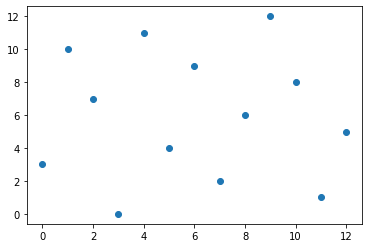

[10000] [[1012, [5, 0, 10, 7, 2, 11, 4, 9, 1, 6, 12, 3, 8]]] [1012, 991, 983, 978, 978, 975, 975, 970, 966, 961] [498]


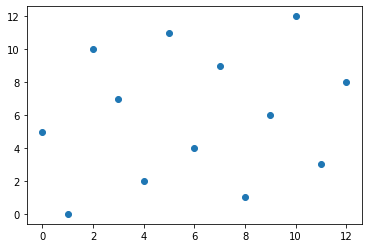

[15000] [[1015, [7, 1, 12, 4, 9, 2, 6, 10, 0, 8, 3, 11, 5]]] [1015, 1015, 1012, 1008, 1008, 1004, 1000, 991, 986, 983] [577]


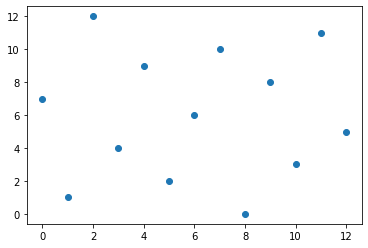

[20000] [[1020, [7, 2, 11, 4, 8, 0, 6, 10, 3, 12, 1, 9, 5]]] [1020, 1017, 1015, 1015, 1015, 1014, 1012, 1009, 1009, 1008] [634]


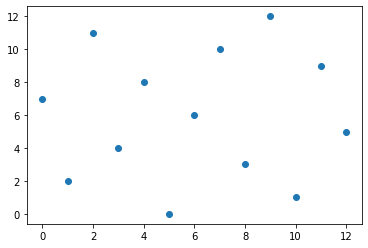

[25000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1054, 1047, 1047, 1047, 1047, 1047, 1047, 1041, 1041] [684]


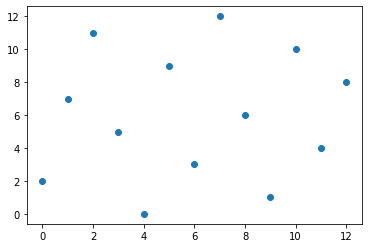

[30000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1054, 1054, 1053, 1047, 1047, 1047, 1047, 1047, 1047] [726]


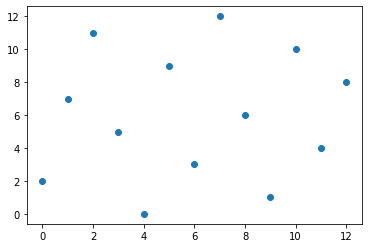

[35000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1054, 1054, 1054, 1054, 1053, 1053, 1053, 1053, 1049] [768]


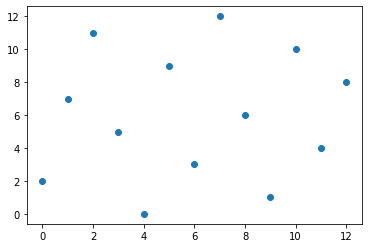

[40000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1065, 1063, 1054, 1054, 1054, 1054, 1054, 1054, 1054] [813]


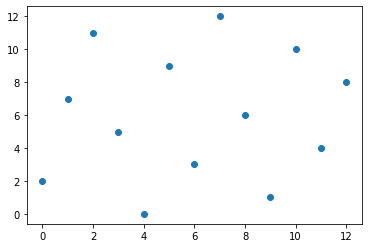

[45000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1065, 1063, 1063, 1063, 1063, 1054, 1054, 1054, 1054] [857]


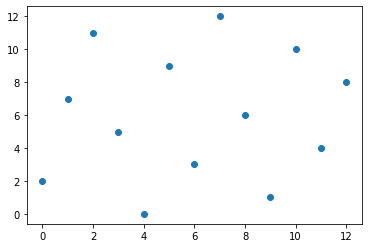

[50000] [[1065, [2, 7, 11, 5, 0, 9, 3, 12, 6, 1, 10, 4, 8]]] [1065, 1065, 1065, 1065, 1063, 1063, 1063, 1063, 1063, 1063] [893]


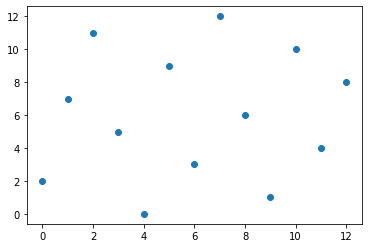

In [24]:
EA = Evolutionary_Algorithm_random_universality(13,7,7000,70000,0.9,40)

In [30]:
EA[0][0]

1065

# Experiments:

* Input: Evolutionary_Algorithm2_universality(13,7,1000,10000,0.8,25): This took around 10 minutes and maxed out at 1007. The correct answer according to Michael's chart is 1094. The maximal permutation is: [9, 2, 6, 12, 0, 8, 4, 10, 1, 5, 11, 7, 3]. The population was 1000, and all 1000 individuals were identical. Let's try with a larger population and a larger parent pool and a larger number of fitness evaluations.

* Input: Evolutionary_Algorithm2_universality(13,7,5000,20000,0.8,30): This took around 20-30 minutes? and maxed out at 1074. The correct answer according to Michael's chart is 1094. The maximal permutation is: [4, 9, 1, 6, 11, 3, 7, 0, 10, 5, 12, 2, 8].

* Input: Evolutionary_Algorithm1_universality(13,7,1000,10000,0.8,25): This took around 10 minutes and maxed out at 964. The correct answer according to Michael's chart is 1094. The maximal permutation is: [7, 1, 10, 3, 6, 11, 0, 4, 8, 12, 2, 9, 5]. Using crossover 1 makes for a slower evolution process rather than crossover 2 but maybe that is okay.

* Input: Evolutionary_Algorithm1_universality(13,7,5000,20000,0.8,30): This took around 20-30 minutes? and maxed out at 979. The correct answer according to Michael's chart is 1094. The maximal permutation is: [9, 1, 5, 11, 3, 7, 0, 4, 8, 12, 2, 10, 6].


* 3: 1063
* 3: 1066

* Evolutionary_Algorithm_random_universality(13,7,5000,20000,0.8,30): 1066
* EA = Evolutionary_Algorithm_random_universality(13,7,7000,50000,0.8,40): 1065


In [22]:
U = [[0]*20 for i in range(20)]

In [23]:
for m in range(1,14):
    for k in range(1,14):
        n = k+m
        EA = Evolutionary_Algorithm_random_universality(n,m,1000,10000,0.8,25)
        U[m][k] = EA[0][0]
        print(U[m][k],(m,k))

1 (1, 1)
1 (1, 2)
1 (1, 3)
1 (1, 4)
1 (1, 5)
1 (1, 6)
1 (1, 7)
1 (1, 8)
1 (1, 9)
1 (1, 10)
1 (1, 11)
1 (1, 12)
1 (1, 13)
2 (2, 1)
2 (2, 2)
2 (2, 3)
2 (2, 4)
2 (2, 5)
2 (2, 6)
2 (2, 7)
2 (2, 8)
2 (2, 9)
2 (2, 10)
2 (2, 11)
2 (2, 12)
2 (2, 13)
4 (3, 1)
6 (3, 2)
6 (3, 3)
6 (3, 4)
6 (3, 5)
6 (3, 6)
6 (3, 7)
6 (3, 8)
6 (3, 9)
6 (3, 10)
6 (3, 11)
6 (3, 12)
6 (3, 13)
5 (4, 1)
12 (4, 2)
19 (4, 3)
23 (4, 4)
24 (4, 5)
24 (4, 6)
24 (4, 7)
24 (4, 8)
24 (4, 9)
24 (4, 10)
24 (4, 11)
24 (4, 12)
24 (4, 13)
6 (5, 1)
21 (5, 2)
41 (5, 3)
71 (5, 4)
94 (5, 5)
109 (5, 6)
119 (5, 7)
119 (5, 8)
120 (5, 9)
120 (5, 10)
120 (5, 11)
120 (5, 12)
120 (5, 13)
7 (6, 1)
28 (6, 2)
75 (6, 3)
156 (6, 4)
273 (6, 5)
392 (6, 6)
495 (6, 7)
594 (6, 8)
662 (6, 9)
695 (6, 10)
712 (6, 11)
719 (6, 12)
720 (6, 13)
8 (7, 1)
36 (7, 2)
113 (7, 3)
291 (7, 4)
610 (7, 5)
1002 (7, 6)
1580 (7, 7)
2286 (7, 8)
2961 (7, 9)
3622 (7, 10)
4238 (7, 11)
4541 (7, 12)
4739 (7, 13)
9 (8, 1)
45 (8, 2)
160 (8, 3)
477 (8, 4)
1049 (8, 5)
2285 (8, 6)
419

KeyboardInterrupt: 

In [25]:
import pandas as pd

In [28]:
pd.DataFrame(U)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0
2,0,2,2,2,2,2,2,2,2,2,2,2,2,2,0,0,0,0,0,0
3,0,4,6,6,6,6,6,6,6,6,6,6,6,6,0,0,0,0,0,0
4,0,5,12,19,23,24,24,24,24,24,24,24,24,24,0,0,0,0,0,0
5,0,6,21,41,71,94,109,119,119,120,120,120,120,120,0,0,0,0,0,0
6,0,7,28,75,156,273,392,495,594,662,695,712,719,720,0,0,0,0,0,0
7,0,8,36,113,291,610,1002,1580,2286,2961,3622,4238,4541,4739,0,0,0,0,0,0
8,0,9,45,160,477,1049,2285,4195,7093,10747,15142,19315,24207,28981,0,0,0,0,0,0
9,0,10,55,217,676,1811,4100,8463,16581,27083,42292,67583,92929,125089,0,0,0,0,0,0


In [34]:
P = [[0]*10 for k in range(14)]
for i in range(14):
    for j in range(10):
        P[i][j] = U[j][i]
pd.DataFrame(P)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,1,2,4,5,6,7,8,9,10
2,0,1,2,6,12,21,28,36,45,55
3,0,1,2,6,19,41,75,113,160,217
4,0,1,2,6,23,71,156,291,477,676
5,0,1,2,6,24,94,273,610,1049,1811
6,0,1,2,6,24,109,392,1002,2285,4100
7,0,1,2,6,24,119,495,1580,4195,8463
8,0,1,2,6,24,119,594,2286,7093,16581
9,0,1,2,6,24,120,662,2961,10747,27083


In [37]:
ME = [[0,0,0,0,0,0,0,0,0,0],
     [0,1,2,4,5,6,7,8,9,10],
     [0,1,2,6,12,21,28,36,45,55],
     [0,1,2,6,19,41,76,114,162,220],
     [0,1,2,6,23,71,156,291,477,699],
     [0,1,2,6,24,94,273,614,1127,1867],
     [0,1,2,6,24,112,408,1094,2356,4368],
     [0,1,2,6,24,119,526,1728,4402,9070],
      [0,1,2,6,24,120,618,2484,7320,17514],
      [0,1,2,6,24,120,683,3212,11391,30728],
      [0,1,2,6,24,120,710,3931,16215,0],
      [0,1,2,6,24,120,720,4383,0,0],
      [0,0,0,0,0,0,0,0,0,0],
      [0,0,0,0,0,0,0,0,0,0]]
      

In [38]:
pd.DataFrame(ME)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,1,2,4,5,6,7,8,9,10
2,0,1,2,6,12,21,28,36,45,55
3,0,1,2,6,19,41,76,114,162,220
4,0,1,2,6,23,71,156,291,477,699
5,0,1,2,6,24,94,273,614,1127,1867
6,0,1,2,6,24,112,408,1094,2356,4368
7,0,1,2,6,24,119,526,1728,4402,9070
8,0,1,2,6,24,120,618,2484,7320,17514
9,0,1,2,6,24,120,683,3212,11391,30728


In [39]:
Difference = [[0]*10 for k in range(14)]
for i in range(14):
    for j in range(10):
        Difference[i][j] = ME[i][j] - P[i][j]
pd.DataFrame(Difference)

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,1,2,3
4,0,0,0,0,0,0,0,0,0,23
5,0,0,0,0,0,0,0,4,78,56
6,0,0,0,0,0,3,16,92,71,268
7,0,0,0,0,0,0,31,148,207,607
8,0,0,0,0,0,1,24,198,227,933
9,0,0,0,0,0,0,21,251,644,3645


In [42]:
Percent = [[0]*10 for k in range(14)]
for i in range(14):
    for j in range(10):
        if ME[i][j] > 0:
            Percent[i][j] = 100*P[i][j]/ME[i][j]
        else:
            Percent[i][j] = 'E'
pd.DataFrame(Percent)

,0,1,2,3,4,5,6,7,8,9
0,E,E,E,E,E,E,E,E,E,E
1,E,100,100,100,100,100,100,100,100,100
2,E,100,100,100,100,100,100,100,100,100
3,E,100,100,100,100,100,98.6842,99.1228,98.7654,98.6364
4,E,100,100,100,100,100,100,100,100,96.7096
5,E,100,100,100,100,100,100,99.3485,93.079,97.0005
6,E,100,100,100,100,97.3214,96.0784,91.5905,96.9864,93.8645
7,E,100,100,100,100,100,94.1065,91.4352,95.2976,93.3076
8,E,100,100,100,100,99.1667,96.1165,92.029,96.8989,94.6728
9,E,100,100,100,100,100,96.9253,92.1856,94.3464,88.1379
